<h1><center>Import necessary libraries and data</center></h1>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn. linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib


In [2]:
# set params for anlysis.
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize']=(5,5)

np.set_printoptions(legacy='1.25')

In [3]:
# Import data
cc_df= pd.read_csv('/Users/michaelperrine/Library/CloudStorage/OneDrive-Personal/Documents/Bellevue/Applied Data Science/AIML Dataset.csv')

In [4]:
# View the first five rows to ensure data loaded properly.
cc_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<h1><center>EDA/Transformations</center></h1>

In [5]:
# View dataset info.
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# Display columns.
cc_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [7]:
# Value count for is fraud column.
cc_df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [8]:
# Value count for is flagged fraud column.
cc_df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [9]:
# Check for null values.
cc_df.isnull().sum().sum()

0

In [10]:
# view the shape of the data.
cc_df.shape

(6362620, 11)

In [11]:
# Calculate the is fraud percentage.
(cc_df['isFraud'].value_counts()[1]/cc_df.shape[0]*100).round(3)

0.129

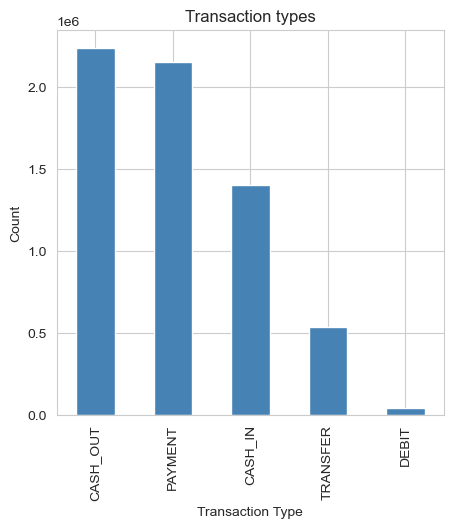

In [12]:
# Graph transaction types.
cc_df['type'].value_counts().plot(kind='bar', title='Transaction types',
                                  color = 'steelblue')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

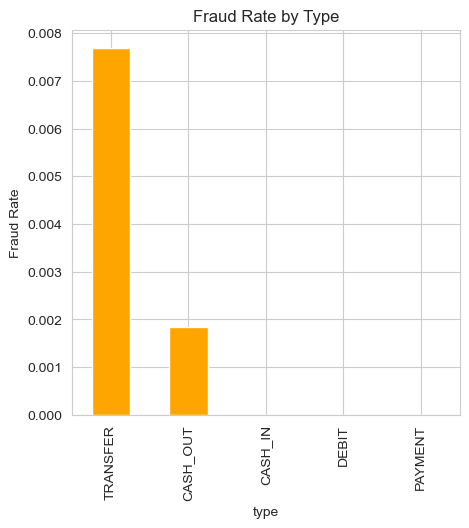

In [13]:
# Graph fraud rate. 
fraud_by_type = cc_df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
fraud_by_type.plot(kind='bar', title='Fraud Rate by Type', color = 'orange')
plt.ylabel('Fraud Rate')
plt.show()

In [14]:
# View fraud by type.
fraud_by_type 

type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

In [15]:
# View descriptive statistics for amount column.
cc_df['amount'].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int64

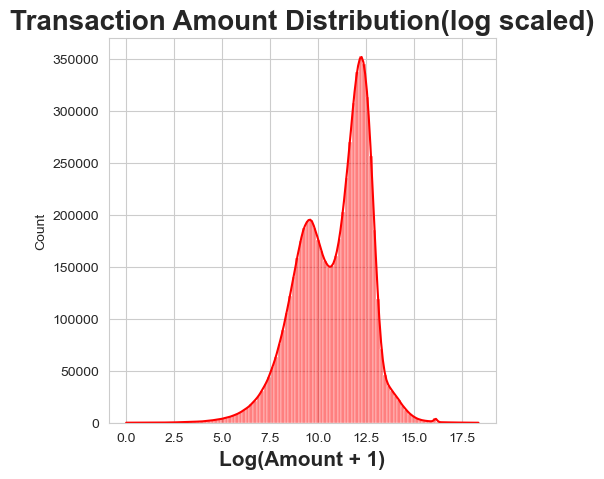

In [16]:
# Graph log distributrion of amount feature.
sns.histplot(np.log1p(cc_df['amount']), bins=100, kde=True, color = 'red')
plt.title('Transaction Amount Distribution(log scaled)', fontsize = 20, weight = 'bold')
plt.xlabel('Log(Amount + 1)', fontsize = 15, weight = 'bold')
plt.show()

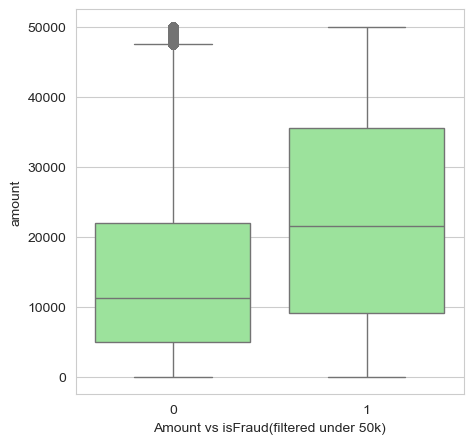

In [17]:
# Create a box plot comparing the amount and isFraud features.
sns.boxplot(data = cc_df[cc_df['amount']< 50000], x = 'isFraud', y = 'amount', color = 'lightgreen')
plt.xlabel('Amount vs isFraud(filtered under 50k)')
plt.show()

In [18]:
# Create new features.
cc_df['balanceDiffOrig'] = cc_df['oldbalanceOrg'] - cc_df['newbalanceOrig']
cc_df['balanceDiffDest'] = cc_df['newbalanceDest'] - cc_df['oldbalanceDest']

In [19]:
# Checking and suming negative values in balanceDiffOrig feature.
(cc_df['balanceDiffOrig']<0).sum()

1399253

In [20]:
# Checking and suming negative values in balanceDiffDest feature.
(cc_df['balanceDiffDest']<0).sum()

1238864

In [21]:
# View the first two rows in dataset.
cc_df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0


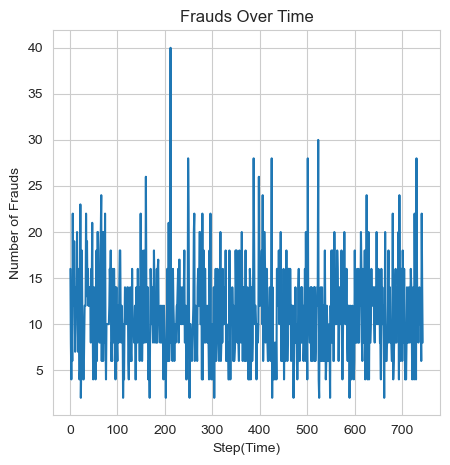

In [22]:
# Test the step feature for time dependence.
fraud_per_step = cc_df[cc_df['isFraud']==1]['step'].value_counts().sort_index()
plt.plot(fraud_per_step.index, fraud_per_step.values, label ='Frauds Per Step')
plt.xlabel('Step(Time)')
plt.ylabel('Number of Frauds')
plt.title('Frauds Over Time')
plt.grid(True)
plt.show()

In [23]:
cc_df.drop(columns='step', inplace=True)

In [24]:
cc_df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [25]:
# Identify and view the top 10 senders.
top_senders = cc_df['nameOrig'].value_counts().head(10)
top_senders

nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64

In [26]:
# Identify and view the top 10 receivers.
top_receivers = cc_df['nameDest'].value_counts().head(10)
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [27]:
# View the top 10 fraud users.
fraud_users = cc_df[cc_df['isFraud']==1]['nameOrig'].value_counts().head(10)
fraud_users

nameOrig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
C1127265876    1
C317779855     1
C1064034527    1
C1141104763    1
C1966863341    1
Name: count, dtype: int64

In [28]:
# Filter  fraud types based on transfer and cash out features.
fraud_types = cc_df[cc_df['type'].isin(['TRANSFER', 'CASH_OUT'])] 
fraud_types.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


In [29]:
# Count the number of fraud types in cash out and transfer.
fraud_types['type'].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

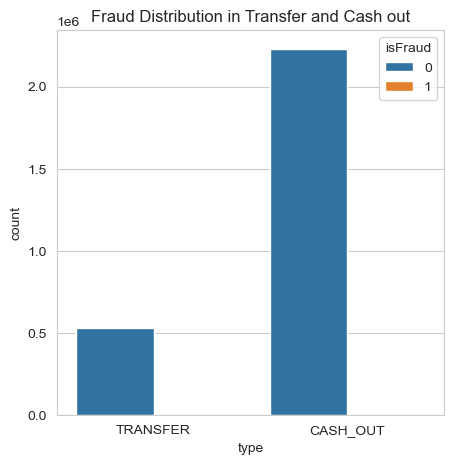

In [30]:
# Graph the fraud types.
sns.countplot(fraud_types, x = 'type', hue = 'isFraud')
plt.title('Fraud Distribution in Transfer and Cash out')
plt.show()

In [31]:
# Create a correlation matrix.
corr = cc_df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest",
              "newbalanceDest", "isFraud"]].corr()
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


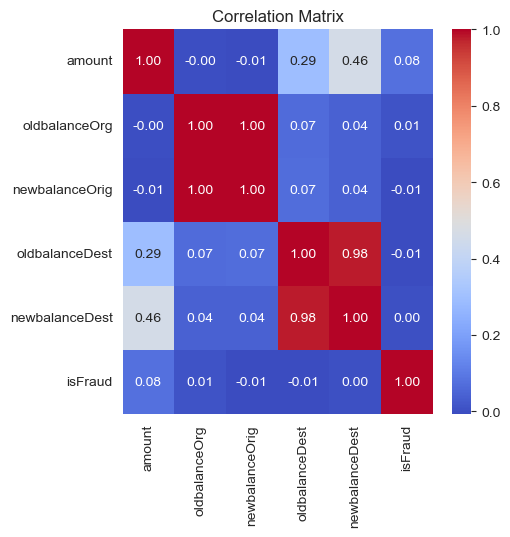

In [32]:
# Visualize correlation matrix with a heatmap.
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [33]:
# Filter transactions that balances end in zero after the transfer date.
zero_after_transfer = cc_df[
     (cc_df['oldbalanceOrg'] > 0) &
     (cc_df['newbalanceOrig'] == 0) &
     (cc_df['type'].isin(['TRANSFER', 'CASH_OUT']))
]

In [34]:
len(zero_after_transfer)

1188074

In [35]:
zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


In [36]:
cc_df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

<h1><center>Model Prep and Building</center><h1>

In [37]:
cc_df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [38]:
# Drop unnecessary features
cc_dfModel = cc_df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

In [39]:
# View new dataframe
cc_dfModel.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,-21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [40]:
# View column names
cc_dfModel.columns

Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'balanceDiffOrig', 'balanceDiffDest'],
      dtype='object')

In [41]:
# Identifying categorical and numerical values
categorical = ['type']
numerical = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest']

In [42]:
# Create X and y variables.
X = cc_dfModel.drop(columns='isFraud', axis = 1)
y = cc_dfModel['isFraud']

In [43]:
# Create training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, 
                                                    stratify = y, random_state = 1)

In [44]:
# Preprocess the data.
preprocessing = ColumnTransformer(
    transformers = [('num', StandardScaler(),numerical),
                    ('cat', OneHotEncoder(drop='first'), categorical)
                    ], remainder='drop'
)

In [45]:
# Create Model Pipeline.
pipeline = Pipeline([
    ('prep', preprocessing),
    ('clf', LogisticRegression(class_weight='balanced',
     max_iter = 1000))
])

In [46]:
# Train model with first 1000 interations
pipeline.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [47]:
# Create a prediction.
y_pred = pipeline.predict(X_test)

In [48]:
# Create classification report.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



In [49]:
# Create confusion matrix.
print(confusion_matrix(y_test, y_pred))

[[1805394  100928]
 [    157    2307]]


In [50]:
pipeline.score(X_test, y_test)* 100

94.70422561774866

In [51]:
joblib.dump(pipeline, 'fraud_detection_pipeline.pkl')

['fraud_detection_pipeline.pkl']